In [1]:
import os
import statistics
from typing import Dict, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches


In [2]:
def load_csv_results():
    normal_scenarios = ["feature_importance", "operator_impact", "data_corruption", "data_cleaning"]
    normal_datasets = ["folktables_1x", "folktables_5x", "folktables_10x", "reviews_1x", "reviews_5x", "reviews_10x"]
    data_loadings = ["fast_loading"]
    featurizations = ["featurization_2"]
    models = ["xgboost"]
    result_df = None
    for scenario in normal_scenarios:
        for dataset in normal_datasets:
            for data_loading in data_loadings:
                for featurization in featurizations:
                    for model in models:
                        filepath = f"{os.getcwd()}/end-to-end-benchmark-results/" \
                                   f"results-{scenario}-{dataset}-{data_loading}-{featurization}-{model}.csv"
                        new_df = pd.read_csv(filepath)
                        if dataset == "reviews_1x":
                            dataset_pretty_name = "reviews"
                            scale_factor = 1
                        elif dataset == "reviews_5x":
                            dataset_pretty_name = "reviews"
                            scale_factor = 5
                        elif dataset == "reviews_10x":
                            dataset_pretty_name = "reviews"
                            scale_factor = 10
                        elif dataset == "folktables_1x":
                            dataset_pretty_name = "folktables"
                            scale_factor = 1
                        elif dataset == "folktables_5x":
                            dataset_pretty_name = "folktables"
                            scale_factor = 5
                        elif dataset == "folktables_10x":
                            dataset_pretty_name = "folktables"
                            scale_factor = 10
                        else:
                            assert False
                        new_df['dataset_pretty'] = dataset_pretty_name
                        new_df['dataset_scale_factor'] = scale_factor
                        new_df['scenario_and_dataset'] =  new_df['dataset_pretty'] + " - " + new_df['scenario']
                        median_no_opt = new_df['total_exec_duration_without_opt'].median()
                        new_df['median_no_opt'] = median_no_opt
                        median_opt = new_df['total_exec_duration_with_opt'].median()
                        new_df['median_opt'] = median_opt
                        new_df['median_opt_plan_generation'] = new_df['opt_what_if_plan_generation'].median()
                        new_df['median_opt_mqo'] = new_df['opt_what_if_query_optimization_duration'].median()
                        new_df['median_opt_other_runtime'] = new_df['total_exec_duration_with_opt'].median() - \
                                                             new_df['opt_original_pipeline_without_importing_and_monkeypatching'].median() - \
                                                             new_df['opt_original_pipeline_importing_and_monkeypatching'].median() - new_df['opt_what_if_execution'].median()
                        median_speedup = median_no_opt / median_opt
                        new_df['median_speedup'] = median_speedup
                        new_df['opt_original_pipeline_estimated'] = new_df['opt_original_pipeline_estimated'].median()
                        new_df['median_original_with_instrum'] = (new_df['opt_original_pipeline_without_importing_and_monkeypatching'] +
                                                                  new_df['opt_original_pipeline_importing_and_monkeypatching']).median()
                        new_df['median_model_training_opt'] = new_df['opt_original_pipeline_model_training'].median() \
                                                              + new_df['opt_what_if_execution_combined_model_training'].median()
                        new_df['median_model_training_no_opt'] = new_df['opt_original_pipeline_model_training'].median() \
                                                              + new_df['no_opt_what_if_execution_combined_model_training'].median()
                        new_df['median_no_opt_wo_orig'] = new_df['median_no_opt'] - new_df['median_original_with_instrum']
                        new_df['median_opt_wo_orig'] = new_df['median_opt'] - new_df['median_original_with_instrum']
                        new_df['median_opt_wo_training'] = new_df['median_opt'] - new_df['median_model_training_opt']
                        new_df['median_no_opt_wo_training'] = new_df['median_no_opt'] - \
                                                              new_df['median_model_training_no_opt']
                        new_df['median_speedup_excluding_model_training'] = new_df['median_no_opt_wo_training'] / \
                                                                            new_df['median_opt_wo_training']
                        # for column in new_df.columns:
                        #     if column.startswith("analysis_result"):
                        #         new_df[column] = median_no_opt / new_df[column].median()
                        new_df['variant_count_including_orig'] = new_df['variant_count'] + 1
                        new_df['max_possible_speedup'] = new_df['variant_count_including_orig'] / 2
                        new_df = new_df[['median_no_opt', 'median_opt', 'median_speedup', 'median_original_with_instrum',
                                         'median_speedup_excluding_model_training',
                                         'median_no_opt_wo_orig', 'median_opt_wo_orig',
                                         'median_opt_plan_generation', 'median_opt_mqo', 'median_opt_other_runtime',
                                         'opt_original_pipeline_estimated', 'variant_count_including_orig',
                                         'max_possible_speedup', 'scenario', 'dataset',
                                         'data_loading', 'featurization', 'model',
                                         'dataset_scale_factor', 'dataset_pretty', 'scenario_and_dataset']]
                        new_df = new_df.head(1)
                        new_df = new_df.round(2)
                        if result_df is None:
                            result_df = new_df
                        else:
                            result_df = pd.concat([result_df, new_df], axis=0)
    return result_df

In [3]:
median_results = load_csv_results()

In [4]:
median_results_ordered_by_median_speedup = median_results.sort_values(by=['median_speedup'])
median_results_ordered_by_median_speedup.to_csv(f"{os.getcwd()}/end-to-end-benchmark-results/1x_5x_10x_speedup_"
                                                f"overview_ordered_by_median_speedup.csv", index=True)
median_results_ordered_by_median_speedup

,median_no_opt,median_opt,median_speedup,median_original_with_instrum,median_speedup_excluding_model_training,median_no_opt_wo_orig,median_opt_wo_orig,median_opt_plan_generation,median_opt_mqo,median_opt_other_runtime,...,variant_count_including_orig,max_possible_speedup,scenario,dataset,data_loading,featurization,model,dataset_scale_factor,dataset_pretty,scenario_and_dataset
0,3.166784e+05,293399.56,1.08,51537.04,2.32,2.651414e+05,241862.52,5.39,22.03,30.08,...,7,3.5,operator_impact,reviews_1x,fast_loading,featurization_2,xgboost,1,reviews,reviews - operator_impact
0,1.172348e+06,1065948.52,1.10,51921.61,3.13,1.120426e+06,1014026.91,0.65,262.00,265.41,...,21,10.5,data_cleaning,reviews_1x,fast_loading,featurization_2,xgboost,1,reviews,reviews - data_cleaning
0,1.135091e+06,949681.03,1.20,182387.52,2.10,9.527035e+05,767293.51,5.35,196.59,204.61,...,7,3.5,operator_impact,reviews_5x,fast_loading,featurization_2,xgboost,5,reviews,reviews - operator_impact
0,4.207854e+06,3376349.59,1.25,182549.50,2.82,4.025305e+06,3193800.09,0.66,274.99,278.63,...,21,10.5,data_cleaning,reviews_5x,fast_loading,featurization_2,xgboost,5,reviews,reviews - data_cleaning
0,2.676701e+06,1894391.66,1.41,460361.68,2.04,2.216339e+06,1434029.97,5.27,21.36,29.35,...,7,3.5,operator_impact,reviews_10x,fast_loading,featurization_2,xgboost,10,reviews,reviews - operator_impact
0,1.008324e+07,6456925.63,1.56,488516.06,2.70,9.594724e+06,5968409.57,0.67,278.28,281.87,...,21,10.5,data_cleaning,reviews_10x,fast_loading,featurization_2,xgboost,10,reviews,reviews - data_cleaning
0,4.264271e+05,234125.60,1.82,15838.14,2.13,4.105890e+05,218287.45,1.23,375.59,379.84,...,34,17.0,data_cleaning,folktables_1x,fast_loading,featurization_2,xgboost,1,folktables,folktables - data_cleaning
0,1.005334e+08,51802026.99,1.94,4909121.83,1.95,9.562432e+07,46892905.16,1.27,377.66,382.33,...,34,17.0,data_cleaning,folktables_10x,fast_loading,featurization_2,xgboost,10,folktables,folktables - data_cleaning
0,2.199637e+07,8571634.24,2.57,764868.90,2.61,2.123151e+07,7806765.34,1.30,401.73,406.38,...,34,17.0,data_cleaning,folktables_5x,fast_loading,featurization_2,xgboost,5,folktables,folktables - data_cleaning
0,1.312376e+05,45393.84,2.89,16853.06,3.68,1.143846e+05,28540.78,5.52,17.42,25.20,...,9,4.5,operator_impact,folktables_1x,fast_loading,featurization_2,xgboost,1,folktables,folktables - operator_impact


In [5]:
median_results_ordered_by_median_speedup_excluding_model_training = median_results\
    .sort_values(by=['median_speedup_excluding_model_training'])
median_results_ordered_by_median_speedup_excluding_model_training.to_csv(f"{os.getcwd()}/end-to-end-benchmark-results/"
                                                                         f"1x_5x_10x_speedup_overview_ordered_by_"
                                                                         f"median_speedup_excluding_model_training.csv",
                                                                         index=True)
median_results_ordered_by_median_speedup_excluding_model_training

,median_no_opt,median_opt,median_speedup,median_original_with_instrum,median_speedup_excluding_model_training,median_no_opt_wo_orig,median_opt_wo_orig,median_opt_plan_generation,median_opt_mqo,median_opt_other_runtime,...,variant_count_including_orig,max_possible_speedup,scenario,dataset,data_loading,featurization,model,dataset_scale_factor,dataset_pretty,scenario_and_dataset
0,1.005334e+08,51802026.99,1.94,4909121.83,1.95,9.562432e+07,46892905.16,1.27,377.66,382.33,...,34,17.0,data_cleaning,folktables_10x,fast_loading,featurization_2,xgboost,10,folktables,folktables - data_cleaning
0,2.676701e+06,1894391.66,1.41,460361.68,2.04,2.216339e+06,1434029.97,5.27,21.36,29.35,...,7,3.5,operator_impact,reviews_10x,fast_loading,featurization_2,xgboost,10,reviews,reviews - operator_impact
0,1.135091e+06,949681.03,1.20,182387.52,2.10,9.527035e+05,767293.51,5.35,196.59,204.61,...,7,3.5,operator_impact,reviews_5x,fast_loading,featurization_2,xgboost,5,reviews,reviews - operator_impact
0,4.264271e+05,234125.60,1.82,15838.14,2.13,4.105890e+05,218287.45,1.23,375.59,379.84,...,34,17.0,data_cleaning,folktables_1x,fast_loading,featurization_2,xgboost,1,folktables,folktables - data_cleaning
0,3.166784e+05,293399.56,1.08,51537.04,2.32,2.651414e+05,241862.52,5.39,22.03,30.08,...,7,3.5,operator_impact,reviews_1x,fast_loading,featurization_2,xgboost,1,reviews,reviews - operator_impact
0,2.199637e+07,8571634.24,2.57,764868.90,2.61,2.123151e+07,7806765.34,1.30,401.73,406.38,...,34,17.0,data_cleaning,folktables_5x,fast_loading,featurization_2,xgboost,5,folktables,folktables - data_cleaning
0,1.008324e+07,6456925.63,1.56,488516.06,2.70,9.594724e+06,5968409.57,0.67,278.28,281.87,...,21,10.5,data_cleaning,reviews_10x,fast_loading,featurization_2,xgboost,10,reviews,reviews - data_cleaning
0,3.111730e+05,105396.28,2.95,51435.29,2.80,2.597377e+05,53960.99,0.21,9.91,12.33,...,6,3.0,feature_importance,reviews_1x,fast_loading,featurization_2,xgboost,1,reviews,reviews - feature_importance
0,1.106293e+06,375370.34,2.95,181903.19,2.81,9.243900e+05,193467.15,0.21,9.73,12.37,...,6,3.0,feature_importance,reviews_5x,fast_loading,featurization_2,xgboost,5,reviews,reviews - feature_importance
0,4.207854e+06,3376349.59,1.25,182549.50,2.82,4.025305e+06,3193800.09,0.66,274.99,278.63,...,21,10.5,data_cleaning,reviews_5x,fast_loading,featurization_2,xgboost,5,reviews,reviews - data_cleaning


In [6]:
def speedup_scatter_plot(data, title, x_column, y_column, groupby_column):
    unique_groupby_values = list(data[groupby_column].unique())
    unique_groupby_values.sort()
    colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange', 'tab:pink', 'tab:purple']
    colors_and_values = list(zip(colors, unique_groupby_values))
    fig, ax = plt.subplots()
    for color, groupby_value in colors_and_values:
        filtered_data = data[data[groupby_column] == groupby_value]
        x = filtered_data[x_column]
        y = filtered_data[y_column]
        ax.scatter(x, y, c=color, label=groupby_value,
                   alpha=1., edgecolors='none')

    plt.plot([0, 45], [0, 22.5], '--', color='grey', label='limit')

    ax.legend(fontsize=15, ncol=1)
    ax.grid(True)
    plt.ylabel('speedup', fontsize=26)
    plt.ylim(0, 22.5)
    plt.xlabel('# variants', fontsize=26)
    plt.xlim(0, 45)

    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)

    print(plt.yticks()[0])
    plt.yticks(list(plt.yticks()[0]) + [1])

    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()

    current_directory = os.getcwd()
    output_directory = os.path.join(current_directory, r'figures')
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.gcf().savefig(f'./figures/{title}.pdf', dpi=300)
    plt.show()

[ 0.  5. 10. 15. 20. 25.]


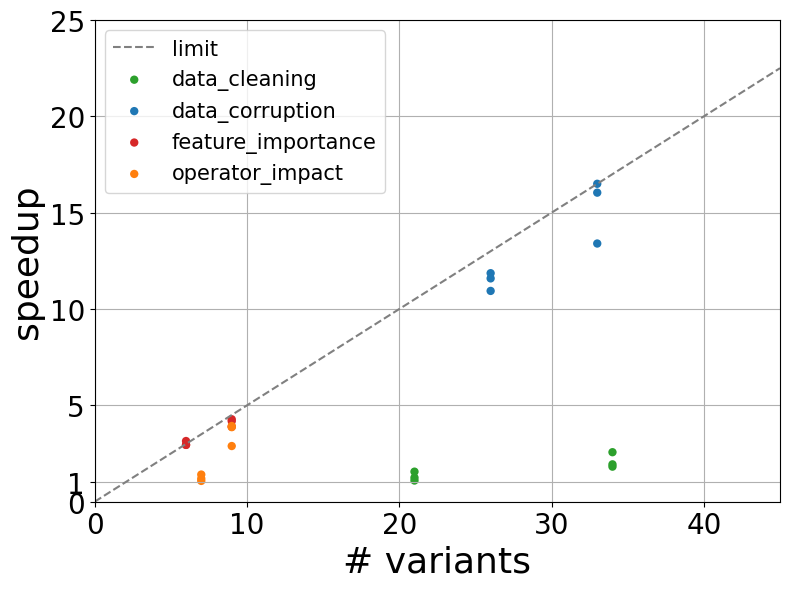

In [7]:
speedup_scatter_plot(median_results, '1x_5x_10x_speedups_per_scenario', 'variant_count_including_orig', 'median_speedup', 'scenario')

[ 0.  5. 10. 15. 20. 25.]


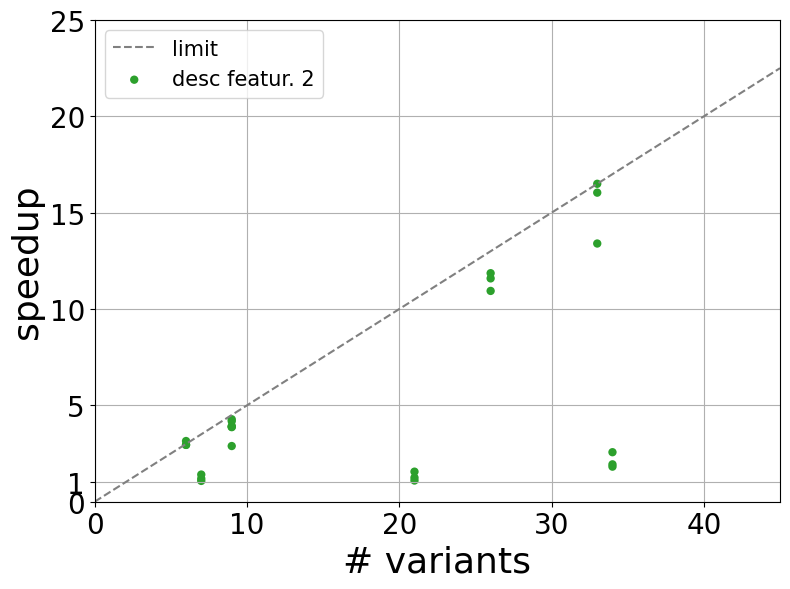

In [8]:
color_map = {
    'featurization_0': 'desc featur. 0',
    'featurization_1': 'desc featur. 1',
    'featurization_2': 'desc featur. 2',
    'featurization_3': 'desc featur. 3',
    'featurization_4': 'desc featur. 4',
    'image': 'desc featur. img'
}
pretty_featurization_desc = median_results.copy(deep=True)
pretty_featurization_desc['featurization'] = pretty_featurization_desc['featurization'].map(color_map)
speedup_scatter_plot(pretty_featurization_desc, '1x_5x_10x_speedups_per_featurization', 'variant_count_including_orig', 'median_speedup', 'featurization')

[ 0.  5. 10. 15. 20. 25.]


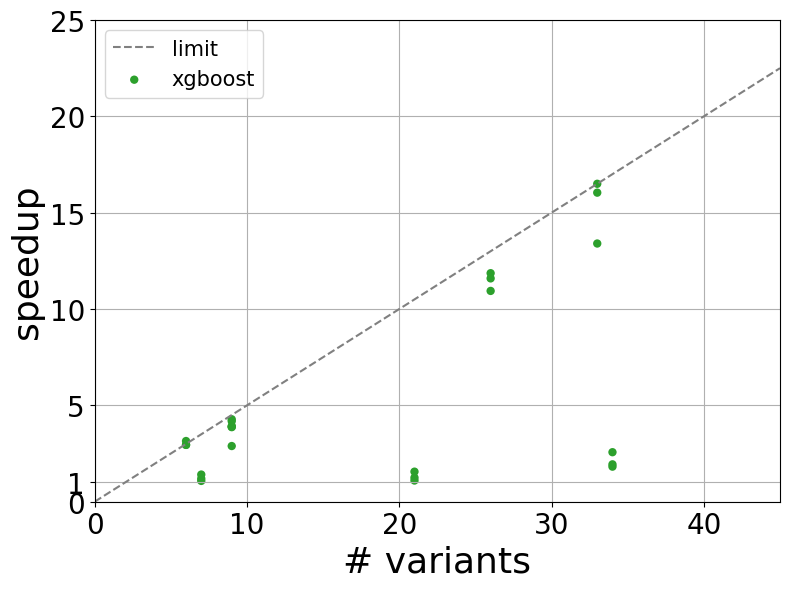

In [9]:
speedup_scatter_plot(pretty_featurization_desc, '1x_5x_10x_speedups_per_model', 'variant_count_including_orig', 'median_speedup', 'model')

[ 0.  5. 10. 15. 20. 25.]


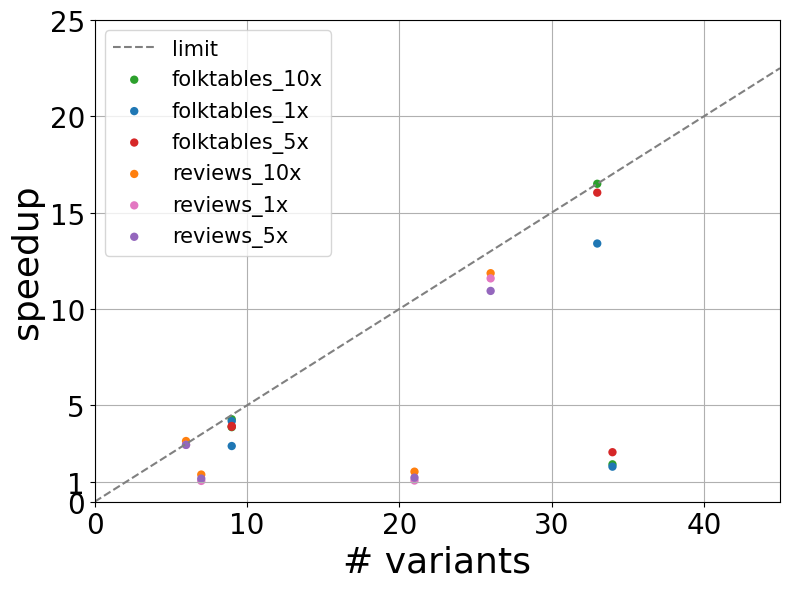

In [10]:
speedup_scatter_plot(pretty_featurization_desc, '1x_5x_10x_speedups_per_dataset', 'variant_count_including_orig', 'median_speedup', 'dataset')

[ 0.  5. 10. 15. 20. 25.]


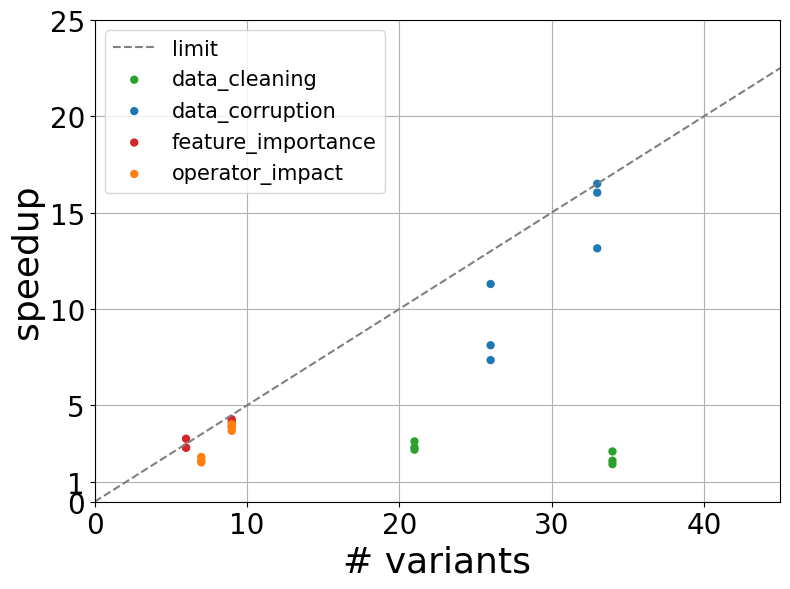

In [11]:
speedup_scatter_plot(median_results, '1x_5x_10x_speedups_per_scenario_excluding_model_training', 'variant_count_including_orig', 'median_speedup_excluding_model_training', 'scenario')

[ 0.  5. 10. 15. 20. 25.]


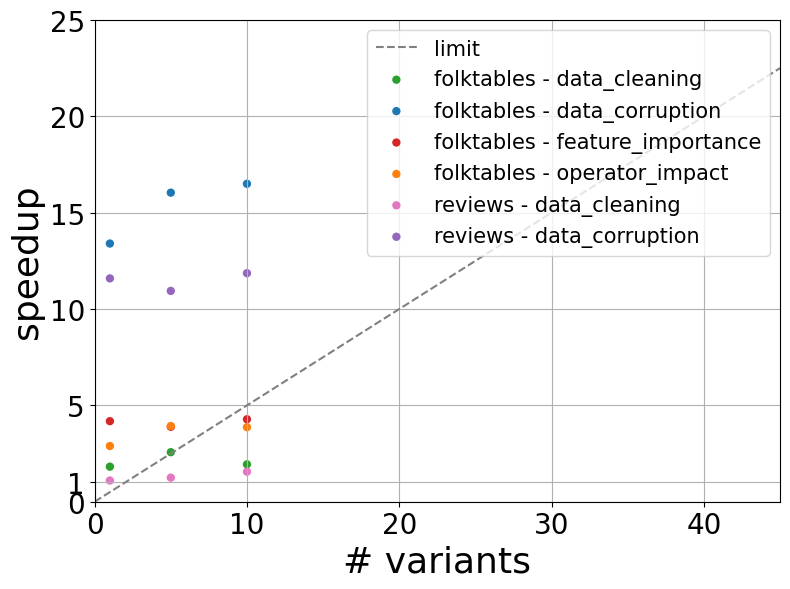

In [12]:
speedup_scatter_plot(median_results, '1x_5x_10x_speedups_scale_factor', 'dataset_scale_factor', 'median_speedup', 'scenario_and_dataset')

[ 0.  5. 10. 15. 20. 25.]


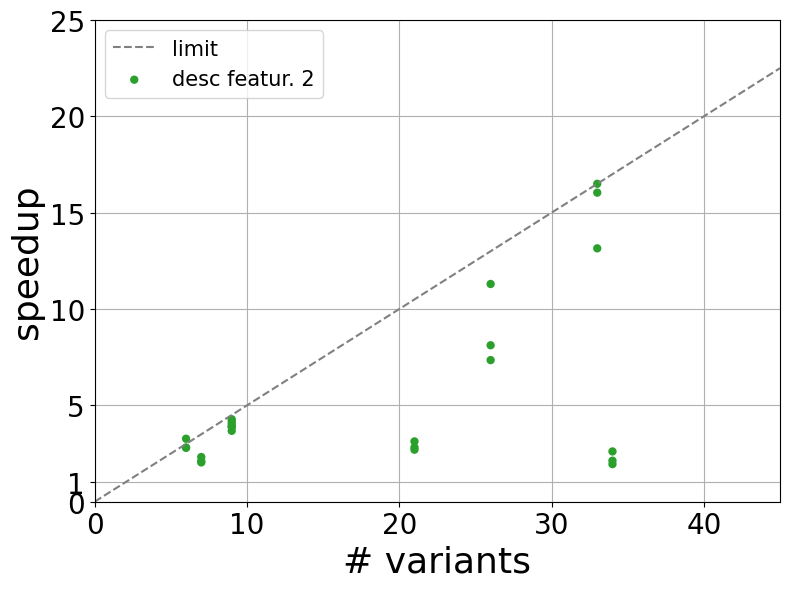

In [13]:
color_map = {
    'featurization_0': 'desc featur. 0',
    'featurization_1': 'desc featur. 1',
    'featurization_2': 'desc featur. 2',
    'featurization_3': 'desc featur. 3',
    'featurization_4': 'desc featur. 4',
    'image': 'desc featur. img'
}
pretty_featurization_desc = median_results.copy(deep=True)
pretty_featurization_desc['featurization'] = pretty_featurization_desc['featurization'].map(color_map)
speedup_scatter_plot(pretty_featurization_desc, '1x_5x_10x_speedups_per_featurization_excluding_model_training', 'variant_count_including_orig', 'median_speedup_excluding_model_training', 'featurization')


[ 0.  5. 10. 15. 20. 25.]


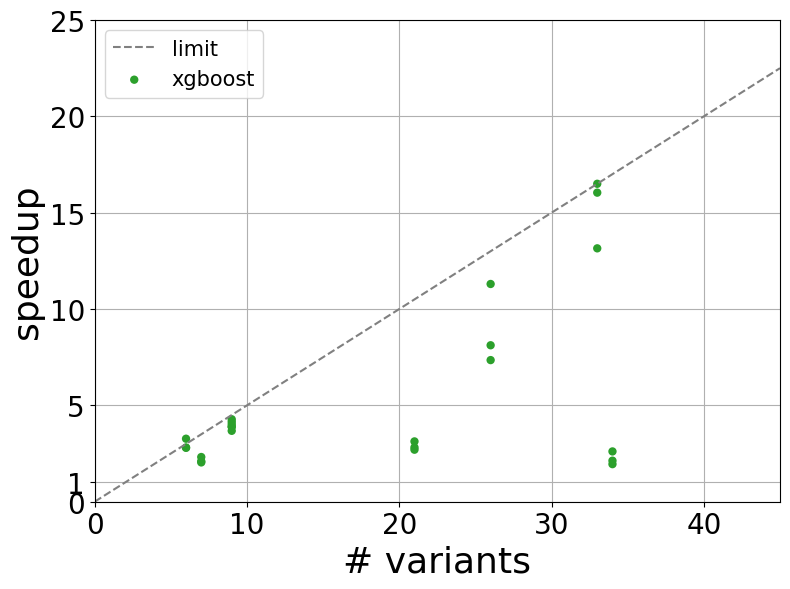

In [14]:
speedup_scatter_plot(pretty_featurization_desc, '1x_5x_10x_speedups_per_model_excluding_model_training', 'variant_count_including_orig', 'median_speedup_excluding_model_training', 'model')

[ 0.  5. 10. 15. 20. 25.]


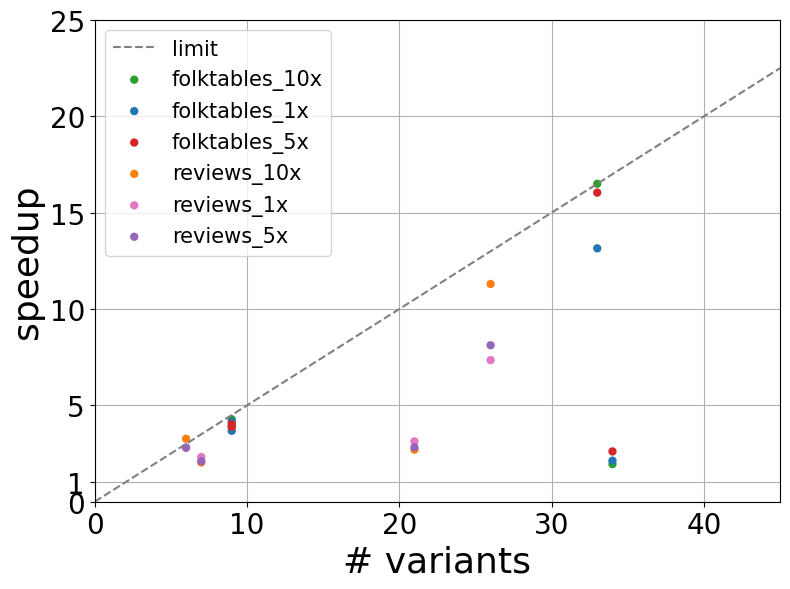

In [15]:
speedup_scatter_plot(pretty_featurization_desc, '1x_5x_10x_speedups_per_dataset_excluding_model_training', 'variant_count_including_orig', 'median_speedup_excluding_model_training', 'dataset')


In [16]:
def speedup_box_plot(data, title, with_outliers, group_col_1, group_col_2, plot_column, absolute_times):
    fig, ax = plt.subplots()

    classes_col1 = list(data[group_col_1].unique())
    classes_col2 = list(data[group_col_2].unique())

    if absolute_times is False:
        colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange', 'tab:pink', 'tab:purple']
    else:
        colors = ['tab:green', 'tab:green', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:orange', 'tab:orange']
    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)


    position = 1
    for group1_index, group1_val in enumerate(classes_col1):
        filtered1_data = data[data[group_col_1] == group1_val]

        for group2_index, (group2_val, color) in enumerate(zip(classes_col2, colors)):
            filtered2_data = filtered1_data[filtered1_data[group_col_2] == group2_val]
            values_to_plot = filtered2_data[plot_column]
            if absolute_times is False:
                box = plt.boxplot([values_to_plot], positions=[position], widths=0.6, showfliers=with_outliers)
                set_box_color(box, color)
            else:
                patch_artist = group2_index % 2 == 1
                box = plt.boxplot([values_to_plot], positions=[position], widths=0.6, showfliers=with_outliers, patch_artist=patch_artist)
                set_box_color(box, color)
                if patch_artist:
                    plt.setp(box['medians'], color='black')
            position += 1
        position += 1
    # ax.legend(fontsize=15, ncol=1)
    # ax.grid(True)
    plt.gca().yaxis.grid(True, linestyle='-.')
    if absolute_times is True:
        plt.ylabel('runtime [s]', fontsize=26)
        plt.ylim(0, None)
    else:
        plt.ylabel('speedup', fontsize=20)
        if with_outliers is False:
            plt.ylim(0, None)
    # plt.xlabel('# rows', fontsize=26)
    # plt.xlim(0, 45)
    ax.set_xticks([len(classes_col2) / 2 + (len(classes_col2) + 1) * group1_index for group1_index, _ in enumerate(classes_col1)])
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xticklabels(classes_col1, fontsize=18)

    for class2, color in zip(classes_col2, colors):
        plt.plot([], c=color, label=class2)
    plt.legend(fontsize=15)

    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()

    current_directory = os.getcwd()
    output_directory = os.path.join(current_directory, r'figures')
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.gcf().savefig(f'./figures/{title}.pdf', dpi=300)
    plt.show()

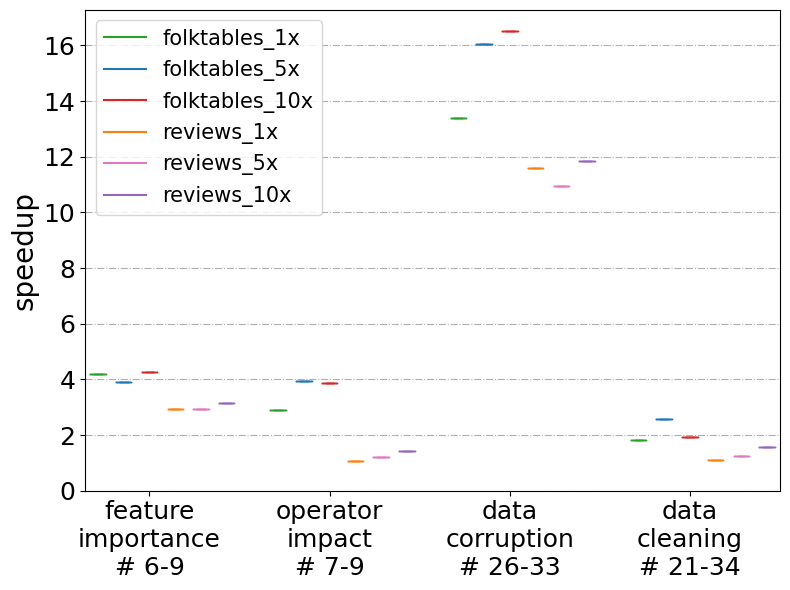

In [17]:
# Without outliers
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
speedup_box_plot(pretty_scenario_names, '1x_5x_10x_speedup_per_scenario_per_dataset_without_outliers', False, 'scenario', 'dataset', 'median_speedup', False)

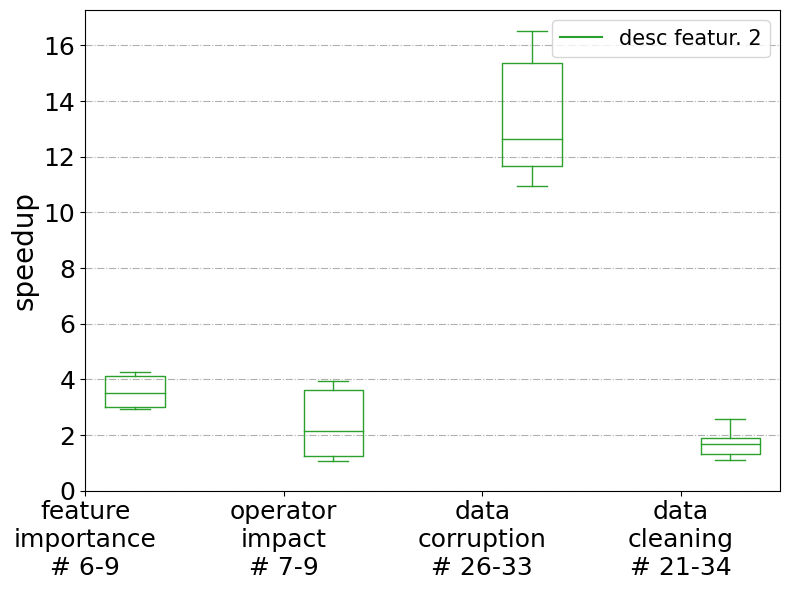

In [18]:
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
featurization_map = {
    'featurization_0': 'desc featur. 0',
    'featurization_1': 'desc featur. 1',
    'featurization_2': 'desc featur. 2',
    'featurization_3': 'desc featur. 3',
    'featurization_4': 'desc featur. 4',
    'image': 'desc featur. img'
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['featurization'] = pretty_scenario_names['featurization'].map(featurization_map)
speedup_box_plot(pretty_scenario_names, '1x_5x_10x_speedup_per_scenario_per_featurization_without_outliers', False, 'scenario', 'featurization', 'median_speedup', False)

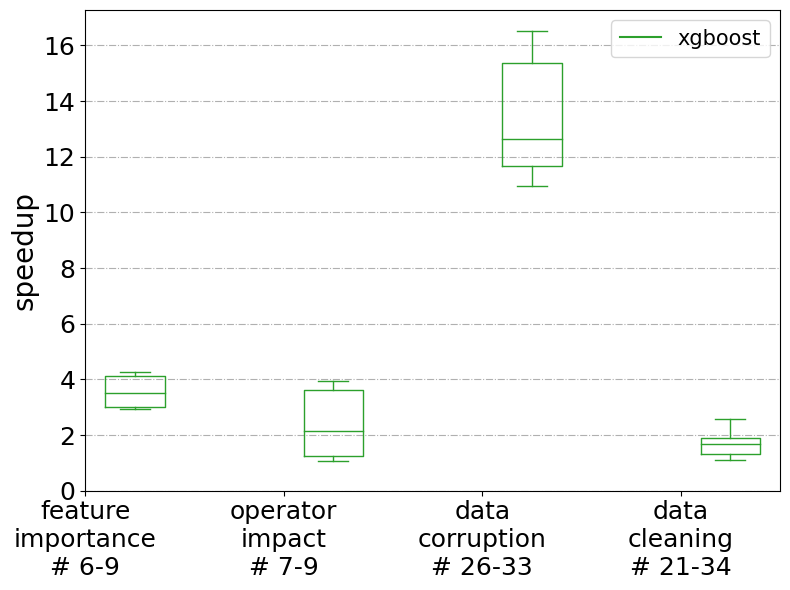

In [19]:
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
model_map = {
    'logistic_regression': 'log. regression',
    'xgboost': 'xgboost',
    'neural_network': 'nn',
    'image': 'cnn',
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['model'] = pretty_scenario_names['model'].map(model_map)
speedup_box_plot(pretty_scenario_names, '1x_5x_10x_speedup_per_scenario_per_model_without_outliers', False, 'scenario', 'model', 'median_speedup', False)

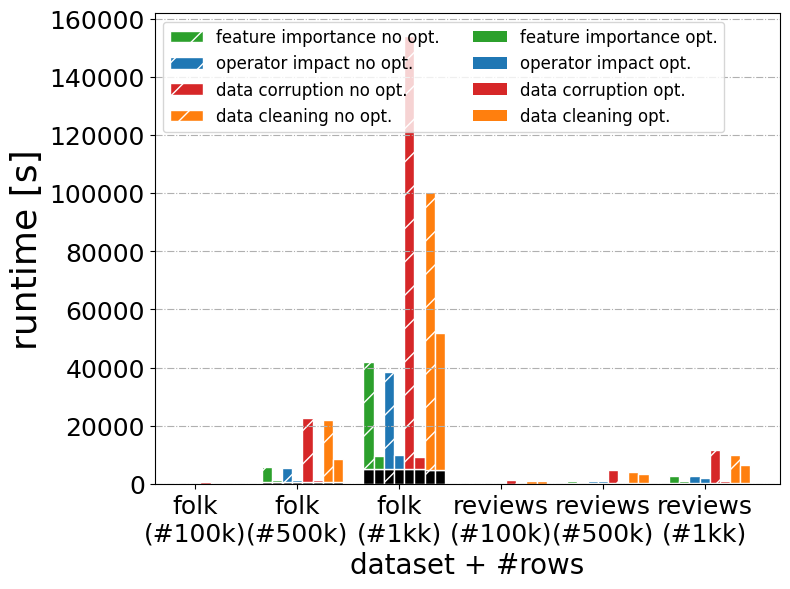

In [20]:
def speedup_bar_plot(data, title, with_outliers, group_col_1, group_col_2, plot_column, absolute_times, orig_pipeline_col, with_bottom=True):
    fig, ax = plt.subplots()
    # ax.set_yscale('log')

    classes_col1 = list(data[group_col_1].unique())
    classes_col2 = list(data[group_col_2].unique())

    if absolute_times is False:
        # colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange', 'tab:pink', 'tab:purple']
        colors = ['tab:green', 'tab:green', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:orange', 'tab:orange']
    else:
        colors = ['tab:green', 'tab:green', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:orange', 'tab:orange']

    position = 1

    def pairwise(iterable):
        "s -> (s0, s1), (s2, s3), (s4, s5), ..."
        a = iter(iterable)
        return zip(a, a)

    for group1_index, group1_val in enumerate(classes_col1):
        filtered1_data = data[data[group_col_1] == group1_val]

        for (group2_val_without, color_without), (group2_val_with, color_with) \
                in pairwise(zip(classes_col2, colors)):
            filtered2_data_without = filtered1_data[filtered1_data[group_col_2] == group2_val_without]
            values_to_plot_without = filtered2_data_without[plot_column]
            filtered2_data_with = filtered1_data[filtered1_data[group_col_2] == group2_val_with]
            values_to_plot_with = filtered2_data_with[plot_column]

            orig_pipeline = filtered2_data_with[orig_pipeline_col]
            orig_pipeline_without = filtered2_data_without[orig_pipeline_col]


            if len(values_to_plot_without) > 0:
                values_diff = values_to_plot_without / values_to_plot_with
                best_case_arg_index = np.argmax(values_diff)
                max_without = values_to_plot_without.iloc[best_case_arg_index]
                max_with = values_to_plot_with.iloc[best_case_arg_index]

                orig_pipeline_value = orig_pipeline.iloc[best_case_arg_index]
                orig_pipeline_value_without = orig_pipeline_without.iloc[best_case_arg_index]
                assert orig_pipeline_value == orig_pipeline_value_without

                if with_bottom is True:
                    bars = plt.bar([position], orig_pipeline_value, width=1., color='black', hatch="/", edgecolor='white')
                    bars = plt.bar([position], max_without, width=1., color=color_without, hatch="/", edgecolor='white', bottom=orig_pipeline_value)
                    bars = plt.bar([position + 1], orig_pipeline_value, width=1., color='black', hatch=None, edgecolor='white')
                    bars = plt.bar([position + 1], max_with, width=1., color=color_with, hatch=None, edgecolor='white', bottom=orig_pipeline_value)
                else:
                    bars = plt.bar([position], max_without, width=1., color=color_without, hatch="/", edgecolor='white')
                    bars = plt.bar([position + 1], max_with, width=1., color=color_with, hatch=None, edgecolor='white')
                # access the bar attributes to place the text in the appropriate location
                # for bar in bars:
                #     yval = bar.get_height()
                #     plus_y_loc = 5
                #     if max_with + 5 >= max_without:
                #         plus_y_loc = 15
                #     plt.text(bar.get_x(), yval + plus_y_loc, round(yval))
                # for bar in bars:
                #     yval = bar.get_height()
                #     plt.text(bar.get_x(), yval + 5, round(yval))
            position += 2
        position += 2
    # ax.legend(fontsize=15, ncol=1)
    # ax.grid(True)
    plt.gca().yaxis.grid(True, linestyle='-.')
    if absolute_times is True:
        plt.ylabel('runtime [s]', fontsize=26)
        plt.ylim(0, None)
    else:
        plt.ylabel('speedup', fontsize=20)
        if with_outliers is False:
            plt.ylim(0, None)
    # plt.xlabel('# rows', fontsize=26)
    plt.xlabel('dataset + #rows', fontsize=20)
    plt.xlim(0, None)
    ax.set_xticks([4 + (len(classes_col2) + 2) * group1_index for group1_index, _ in enumerate(classes_col1)])
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xticklabels(classes_col1, fontsize=18)

    handles1 = []
    handles2 = []
    # handles.append(patches.Patch( facecolor='grey',hatch="/",label='no opt.'))
    # handles.append(patches.Patch( facecolor='grey',hatch=None,label='opt.'))
    for class_index, (class2, color) in enumerate(zip(classes_col2, colors)):
        # class2_name = class2.replace(" no opt.", "")
        if (class_index % 2) == 0:
            handles1.append(patches.Patch(facecolor=color,edgecolor='white', hatch="/",label=class2))
        else:
            handles2.append(patches.Patch(facecolor=color,hatch=None,label=class2))

        # patches.Patch( facecolor='grey',hatch="/",label='no. opt')
        # line = plt.plot([], c=color, label=class2_name)[0]
        # handles.append(line)
    plt.legend(fontsize=12, handles=handles1 + handles2, loc="upper left", ncol=2)

    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()

    current_directory = os.getcwd()
    output_directory = os.path.join(current_directory, r'figures')
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.gcf().savefig(f'./figures/{title}.pdf', dpi=300)
    plt.show()

scenario_names = {
    'feature_importance': 'feature importance',
    'operator_impact': 'operator impact',
    'data_cleaning': 'data cleaning',
    'data_corruption': 'data corruption',
}
model_map = {
    'logistic_regression': 'log. regression',
    'xgboost': 'xgboost',
    'neural_network': 'nn',
    'image': 'cnn',
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['model'] = pretty_scenario_names['model'].map(model_map)
pretty_scenario_names['run'] = pretty_scenario_names['model'].map(model_map)

with_opt = pretty_scenario_names.copy()
with_opt['runtime'] = with_opt['median_opt_wo_orig'] / 1000
with_opt['scenario'] = with_opt['scenario'] + " opt."

no_opt = pretty_scenario_names.copy()
no_opt['runtime'] = no_opt['median_no_opt_wo_orig'] / 1000
no_opt['scenario'] = no_opt['scenario'] + " no opt."

data_set_sort_order = {
    'folktables_1x': 0,
    'folktables_5x': 1,
    'folktables_10x': 2,
    'reviews_1x': 3,
    'reviews_5x': 4,
    'reviews_10x': 5,
}
scenario_sort_order = {
    'feature importance no opt.': 0,
    'feature importance opt.': 1,
    'operator impact no opt.': 2,
    'operator impact opt.': 3,
    'data corruption no opt.': 4,
    'data corruption opt.': 5,
    'data cleaning no opt.': 6,
    'data cleaning opt.': 7
}
data_set_row_count_map = {
    'folktables_1x': 'folk\n(#100k)',
    'folktables_5x': 'folk\n(#500k)',
    'folktables_10x': 'folk\n(#1kk)',
    'reviews_1x': 'reviews\n(#100k)',
    'reviews_5x': 'reviews\n(#500k)',
    'reviews_10x': 'reviews\n(#1kk)',
}
opt_and_no_opt = pd.concat([with_opt, no_opt], axis=0)
opt_and_no_opt["dataset_sort_order"] = opt_and_no_opt["dataset"].map(data_set_sort_order)
opt_and_no_opt["scenario_sort_order"] = opt_and_no_opt["scenario"].map(scenario_sort_order)
opt_and_no_opt = opt_and_no_opt.sort_values(["dataset_sort_order", "scenario_sort_order"])
opt_and_no_opt['dataset'] = opt_and_no_opt['dataset'].map(data_set_row_count_map)
opt_and_no_opt['median_original_with_instrum'] = opt_and_no_opt['median_original_with_instrum'] / 1000
speedup_bar_plot(opt_and_no_opt, '1x_5x_10x_runtime_w_and_wo_per_dataset_per_scenario_without_outliers', False, 'dataset', 'scenario', 'runtime', True, 'median_original_with_instrum')

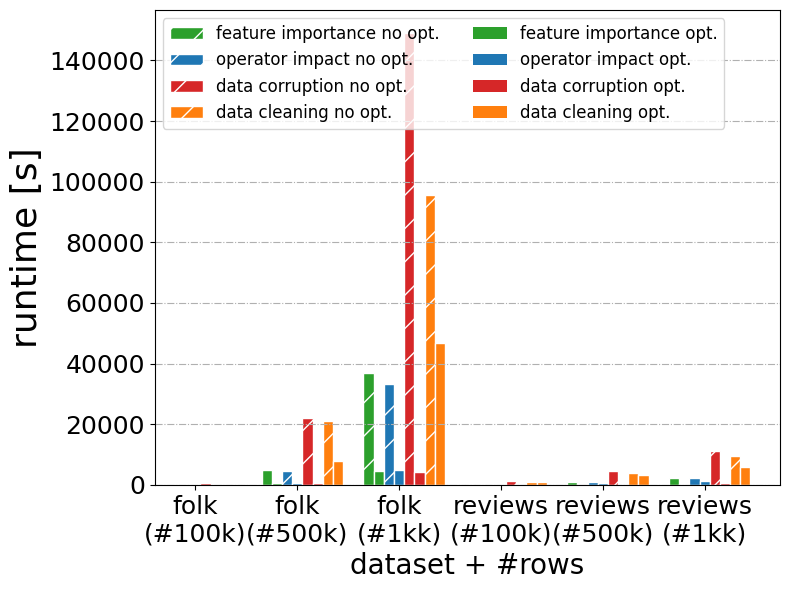

In [21]:
speedup_bar_plot(opt_and_no_opt, '1x_5x_10x_runtime_w_and_wo_per_dataset_per_scenario_without_outliers', False, 'dataset', 'scenario', 'runtime', True, 'median_original_with_instrum', False)


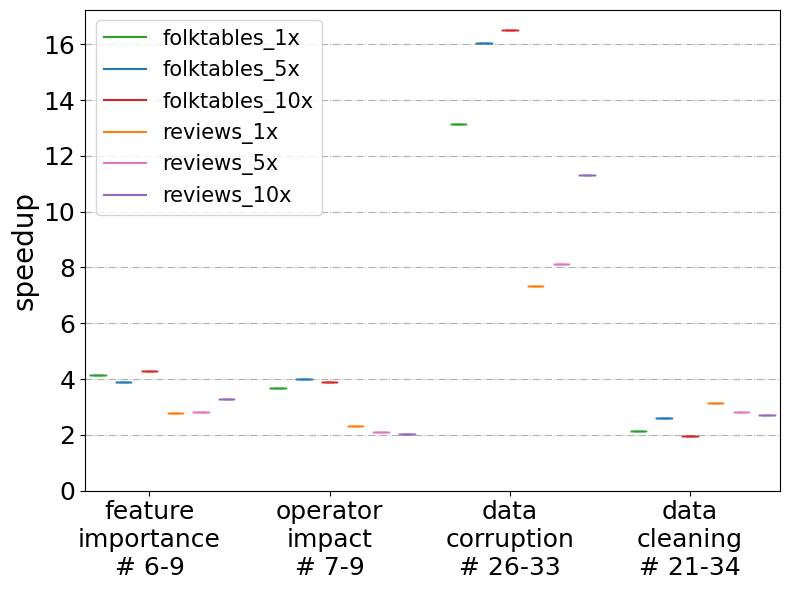

In [22]:
# Without outliers
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
speedup_box_plot(pretty_scenario_names, '1x_5x_10x_speedup_wo_training_per_scenario_per_dataset_without_outliers', False, 'scenario', 'dataset', 'median_speedup_excluding_model_training', False)


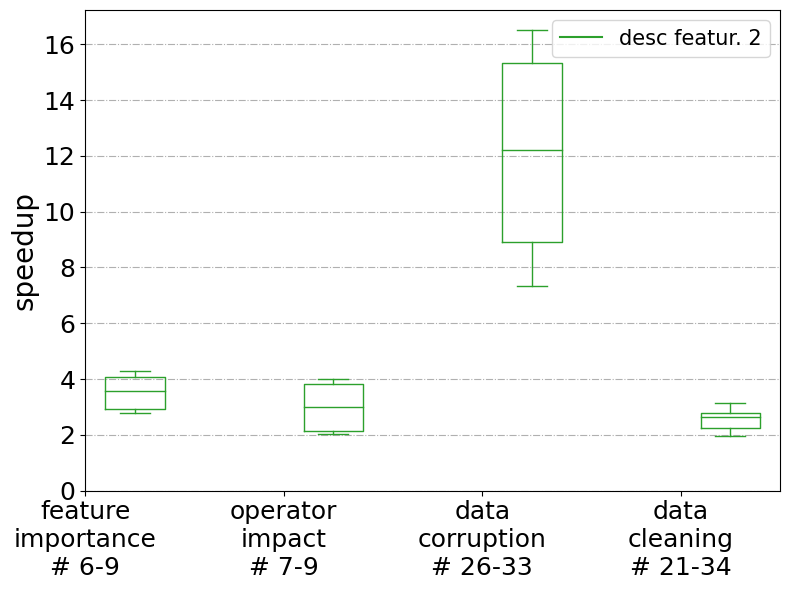

In [23]:
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
featurization_map = {
    'featurization_0': 'desc featur. 0',
    'featurization_1': 'desc featur. 1',
    'featurization_2': 'desc featur. 2',
    'featurization_3': 'desc featur. 3',
    'featurization_4': 'desc featur. 4',
    'image': 'desc featur. img'
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['featurization'] = pretty_scenario_names['featurization'].map(featurization_map)
speedup_box_plot(pretty_scenario_names, '1x_5x_10x_speedup_wo_training_per_scenario_per_featurization_without_outliers', False, 'scenario', 'featurization', 'median_speedup_excluding_model_training', False)

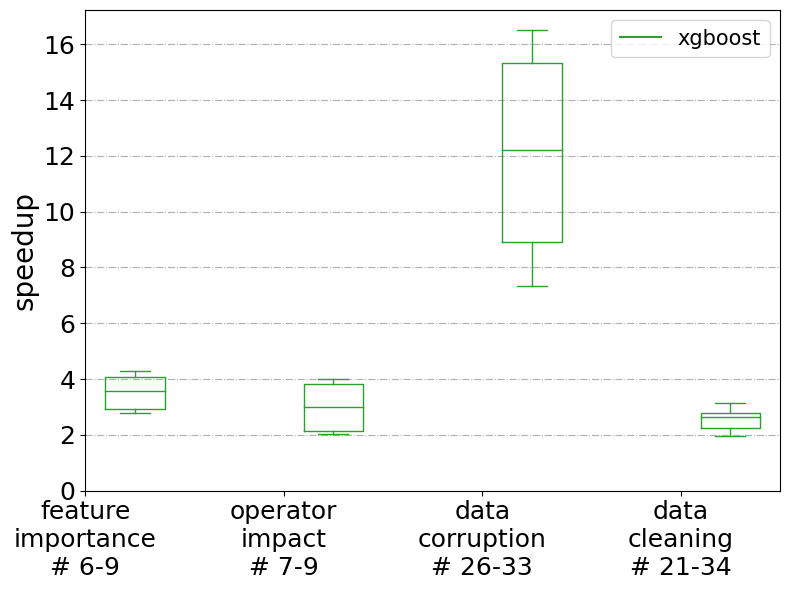

In [24]:
# FIXME: Is w/o training bugged?
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
model_map = {
    'logistic_regression': 'log. regression',
    'xgboost': 'xgboost',
    'neural_network': 'nn',
    'image': 'cnn',
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['model'] = pretty_scenario_names['model'].map(model_map)
speedup_box_plot(pretty_scenario_names, '1x_5x_10x_speedup_wo_training_per_scenario_per_model_without_outliers', False, 'scenario', 'model', 'median_speedup_excluding_model_training', False)

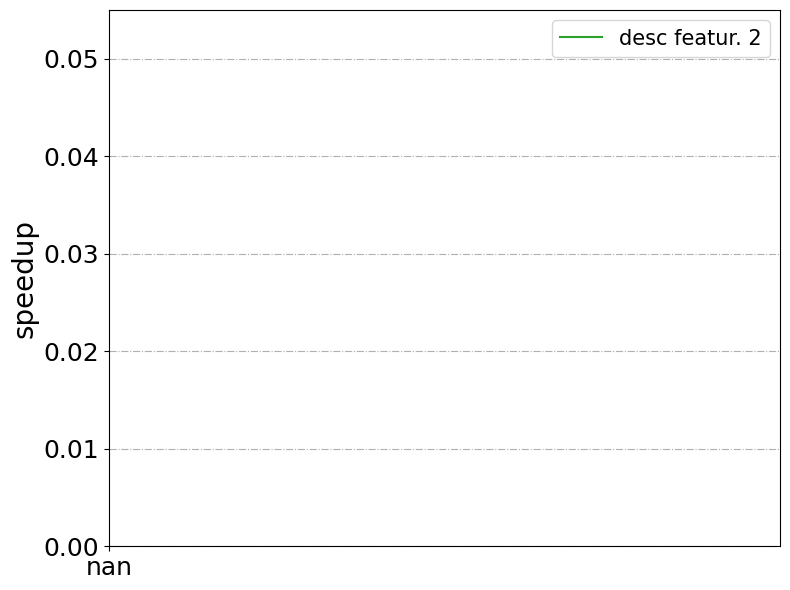

In [25]:
data_set_join_info_map = {
    'healthcare': 'healthcare\n(fuzzy join,\nwith text)',
    'sneakers': 'sneakers\n(1 join,\nwith images)',
    'folktables': 'folktables\n(0 joins,\nno text)',
    'cardio': 'cardio\n(2 joins,\nno text)',
    'reviews': 'reviews\n(3 joins,\nwith text)',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
featurization_map = {
    'featurization_0': 'desc featur. 0',
    'featurization_1': 'desc featur. 1',
    'featurization_2': 'desc featur. 2',
    'featurization_3': 'desc featur. 3',
    'featurization_4': 'desc featur. 4',
    'image': 'desc featur. img'
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['dataset'] = pretty_scenario_names['dataset'].map(data_set_join_info_map)
pretty_scenario_names['featurization'] = pretty_scenario_names['featurization'].map(featurization_map)
speedup_box_plot(pretty_scenario_names, '1x_5x_10x_speedup_wo_training_per_dataset_per_featurization_without_outliers', False, 'dataset', 'featurization', 'median_speedup_excluding_model_training', False)

In [26]:
print("max other runtime is calculated by using total runtime, substracting orig execution and instrumentation, and "
      "substracting what-if combined plan execution")
print()

print(f"all datasets: max optimization duration: {median_results['median_opt_mqo'].max()}")
print(f"all datasets: max variant generation: {median_results['median_opt_plan_generation'].max()}")
print(f"all datasets: max other runtime: {median_results['median_opt_other_runtime'].max()}")
print()

print(f"all datasets: p95 optimization duration: {median_results['median_opt_mqo'].quantile(.95)}")
print(f"all datasets: p95 variant generation: {median_results['median_opt_plan_generation'].quantile(.95)}")
print(f"all datasets: p95 other runtime: {median_results['median_opt_other_runtime'].quantile(.95)}")
print()

print(f"all datasets: p90 optimization duration: {median_results['median_opt_mqo'].quantile(.9)}")
print(f"all datasets: p90 variant generation: {median_results['median_opt_plan_generation'].quantile(.9)}")
print(f"all datasets: p90 other runtime: {median_results['median_opt_other_runtime'].quantile(.9)}")
print()

print(f"all datasets: median optimization duration: {median_results['median_opt_mqo'].median()}")
print(f"all datasets: median variant generation: {median_results['median_opt_plan_generation'].median()}")
print(f"all datasets: median other runtime: {median_results['median_opt_other_runtime'].median()}")
print()

print(f"all datasets: p5 optimization duration: {median_results['median_opt_mqo'].quantile(.05)}")
print(f"all datasets: p5 variant generation: {median_results['median_opt_plan_generation'].quantile(.05)}")
print(f"all datasets: p5 other runtime: {median_results['median_opt_other_runtime'].quantile(.05)}")
print()

print(f"all datasets: min optimization duration: {median_results['median_opt_mqo'].min()}")
print(f"all datasets: min variant generation: {median_results['median_opt_plan_generation'].min()}")
print(f"all datasets: min other runtime: {median_results['median_opt_other_runtime'].min()}")
print()

max other runtime is calculated by using total runtime, substracting orig execution and instrumentation, and substracting what-if combined plan execution

all datasets: max optimization duration: 401.73
all datasets: max variant generation: 5.65
all datasets: max other runtime: 406.38

all datasets: p95 optimization duration: 377.34950000000003
all datasets: p95 variant generation: 5.5184999999999995
all datasets: p95 other runtime: 381.95649999999995

all datasets: p90 optimization duration: 346.39699999999993
all datasets: p90 variant generation: 5.473999999999999
all datasets: p90 other runtime: 350.4489999999999

all datasets: median optimization duration: 214.07
all datasets: median variant generation: 0.635
all datasets: median other runtime: 219.54500000000002

all datasets: p5 optimization duration: 9.9265
all datasets: p5 variant generation: 0.216
all datasets: p5 other runtime: 12.4525

all datasets: min optimization duration: 9.73
all datasets: min variant generation: 0.21
a

In [27]:
def plot_runtime_scaling(scenario_name_to_named_metrics: Dict[str, Tuple[float, float]],
                         variant_counts, title):

    markersize = 12

    #plt.plot(1.0 / epsilons, adult_means / np.min(adult_means), 'o-', markersize=markersize)

    # plt.plot(variant_counts, np.array(orig), linestyle='dotted', color='grey')
    # styles = [{'color': 'tab:green'}, {'color': 'tab:blue'}, {'color': 'tab:red'}, {'color': 'tab:orange'}, {'color': 'tab:red', 'linestyle': 'dashed'}, {'color': 'tab:purple', 'linestyle': 'dashed'}]
    # styles = [{'color': 'tab:green'}, {'color': 'tab:blue'}, {'color': 'tab:red'}, {'color': 'tab:orange'}, {'color': 'tab:pink'}, {'color': 'tab:purple'}]
    styles = [{'color': 'tab:green'}, {'color': 'tab:blue'}, {'color': 'tab:red'}, {'color': 'tab:orange'}, {'color': 'tab:green'}, {'color': 'tab:blue'}, {'color': 'tab:red'}, {'color': 'tab:orange'}]


    for (scenario, metric_with_opt), style in zip(scenario_name_to_named_metrics.items(), styles):
        plt.plot(variant_counts, np.array(metric_with_opt), marker='o', **style)
        #plt.plot(variant_counts, np.array(metric_witout_opt), linestyle='dashed', marker='o', **style)


    #plt.ylim((0.9, 5.999))
    # plt.grid()
    # plt.gca().set_aspect("equal")

    plt.ylabel('speedup', fontsize=26)
    legend_names = []
    for scenario_name in scenario_name_to_named_metrics.keys():
        with_opt_desc = scenario_name
        legend_names.append(f"{with_opt_desc}")  #  w/ opt.
        # legend_names.append(f"{without_opt_desc}")
    plt.legend(legend_names, loc='upper left',
               #, title="inspections", title_fontsize=16,
               fontsize=15, ncol=1)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)

    #plt.xticks(variant_counts[1:], rotation=45, fontsize=24)
    plt.xticks(variant_counts, rotation=0, fontsize=24)
    # plt.xticks(list(range(2, variant_counts[-1])), rotation=0, fontsize=24)


    if isinstance(variant_counts[-1], int):  # TODO: Do this in a less hacky way
        # variant counts
        plt.xlabel('scale factor', fontsize=26)
        # plt.yticks(list(range(variant_counts[-1])))
        # plt.ylim(0, variant_counts[-1])

    #plt.yscale('log')
    #plt.xscale('log')


    #plt.title(title, fontsize=26)

    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()

    current_directory = os.getcwd()
    output_directory = os.path.join(current_directory, r'figures')
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.gcf().savefig(f'./figures/{title}.pdf', dpi=300)
    plt.show()

   dataset_scale_factor        scenario_and_dataset
0                     1  folktables - data_cleaning
0                     5  folktables - data_cleaning
0                    10  folktables - data_cleaning
   dataset_scale_factor          scenario_and_dataset
0                     1  folktables - data_corruption
0                     5  folktables - data_corruption
0                    10  folktables - data_corruption
   dataset_scale_factor             scenario_and_dataset
0                     1  folktables - feature_importance
0                     5  folktables - feature_importance
0                    10  folktables - feature_importance
   dataset_scale_factor          scenario_and_dataset
0                     1  folktables - operator_impact
0                     5  folktables - operator_impact
0                    10  folktables - operator_impact
   dataset_scale_factor     scenario_and_dataset
0                     1  reviews - data_cleaning
0                     5  reviews -

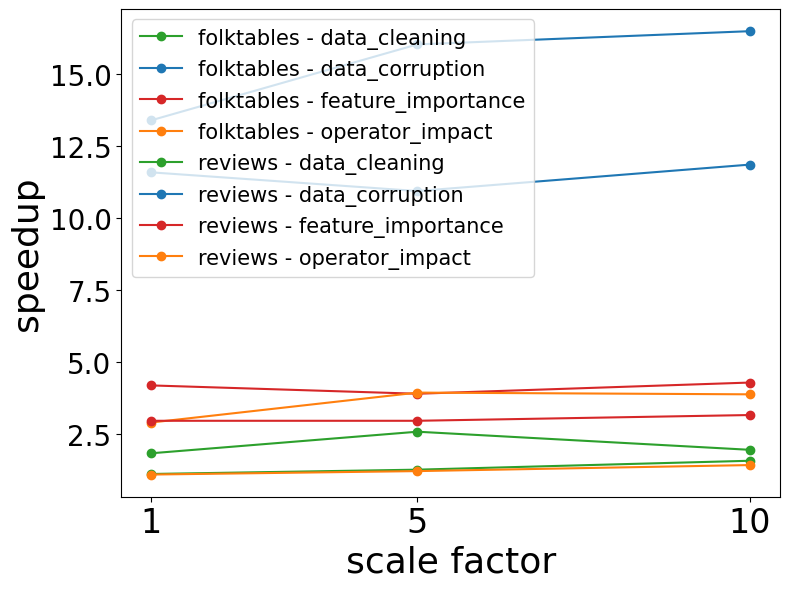

In [28]:
optimization = "scalability"
variant_counts = [1, 5, 10]
unique_groupby_values = list(median_results["scenario_and_dataset"].unique())
unique_groupby_values.sort()
named_lines_to_plot = {}
for scenario_and_dataset in unique_groupby_values:
    values_to_plot = median_results[median_results["scenario_and_dataset"] == scenario_and_dataset]
    values_to_plot.sort_values(by=['dataset_scale_factor'])
    print(values_to_plot[['dataset_scale_factor', "scenario_and_dataset"]])
    values_to_plot = values_to_plot["median_speedup"]
    named_lines_to_plot[scenario_and_dataset] = values_to_plot

plot_runtime_scaling(named_lines_to_plot, variant_counts, f"scalability_all")
